In [1092]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import pickle
import time
import os
import re

os.chdir("/home/s2113174/Projects-1")

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{du}{dt} - \alpha cos(2\pi t)=0$$

with solution 
$$ u(t) = \alpha \frac{sin ( 2 \pi t )}{2 \pi} + 1$$

## Problem: Try to find the weeknesses of the model

## Feed Forward Neural Network

In [1093]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [1094]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - pr*torch.cos( 2*torch.pi *t)
    return f

In [1095]:
DNN.DE = DE

In [1096]:
def sample_ic(size):
    return np.zeros(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return min + np.random.rand(size)*max

In [1097]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic, t, param = sample_ic(size),samples_space(size,maxl),samples_param(minp,maxp,size)

    ic, t, param = torch.tensor(ic).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

    ic, t, param = Variable(ic,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,f_pred = pinn(torch.cat([ic, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_f = loss(ic_pred,torch.ones_like(t)),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [1098]:
def test_set(max_space,obs,param,mean,std):

    t= np.linspace(0,max_space,obs)

    sol = (param/ (2*np.pi))*np.sin(2*np.pi*t)+1

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

In [1099]:
def log_prior_alpha(alpha, m = 0, sd = 1): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = m,scale = sd)
#
def log_prior_sig(sig): #function to evaluate prior pdf for sigma^2
    return uniform(loc=0.,scale=1).logpdf(sig)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [1100]:
def log_likelihood(surrogate,alpha,t,y_dat,sig = 1):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

# def log_likelihood_ex(alpha,t,y,sig = 1):

#     surg_exact = (alpha/ (2*np.pi))*np.sin(2*np.pi*t) + 1

#     #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
#     return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [1101]:
#def log_posterior_ex(alpha,t,y,sig):
#    return  log_likelihood_ex(alpha,t,y,sig = sig) + log_prior_alpha(alpha)

def log_posterior_ex(alpha_,t,y,sig,sig_0):
    N = len(y)

    A = np.sum((np.sin(2*np.pi*t)/(2*np.pi*sig))**2 + 1/(N*sig_0)**2)

    mu_p = np.sum((np.sin(2*np.pi*t)/(2*np.pi*sig**2)) * ((y -1)/A))

    return np.log(np.sqrt(np.prod(A)/(2*np.pi)) * np.exp(-0.5 * np.sum((A*((alpha_.reshape(-1,1)- mu_p)**2)),axis = 1)))


def log_posterior_nn(model,alpha,t,y,sig,sig_0 = 1):
    return  log_likelihood(model,alpha,t,y,sig = sig) + log_prior_alpha(alpha,sd = sig_0)

In [1102]:
#seed  = 42
#rng = np.random.default_rng(seed)
#np.random.seed(seed)

lr = 0.01    #Learning Rate
ns = 3       #Time space limit

mean, std = 0,0.1  #Gaussian Noise

min_param , max_param = 0, 10 #Range of Parameters for the parametric ODE

true_theta = 3.5
sig_0 = 10


t, noise_sol_test = test_set(ns,2200,true_theta,mean,std) #Test data for the MCMC

layers = [2] + 5*[50] + [1]   #Architecture of NN

epochs = [10,100,150] #Number of Epochs
nobs = [100,200,300,400,500]


times = dict()

In [1103]:
# for epoch in epochs:
#     times[str(epoch)] = []

#     for obs in nobs:
#         print(f"Starting training of the model with {obs} observations and {epoch} epochs")

#         start_time = time.perf_counter()
        
#         #torch.manual_seed(seed)
#         model = DNN(layers)

#         loss = torch.nn.MSELoss(reduction ='mean')

#         optimizer = torch.optim.LBFGS(
#             model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe")

#         train(epoch, model,loss,optimizer,obs,ns,min_param,max_param)
        
#         end_time = time.perf_counter()

#         times[str(epoch)].append(end_time - start_time) 

#         torch.save(model.state_dict(),"ODE_Models/Param_model_"+str(epoch)+"_"+str(obs)+".pt")

In [1104]:
# save dictionary to person_data.pkl file

# with open('times.pkl', 'wb') as fp:
#     pickle.dump(times, fp)


with open('times.pkl', 'rb') as fp:
    times = pickle.load(fp)

In [1105]:
# file_models = os.listdir("ODE_Models")
# file_models = [s for s in file_models if s in ['Param_model_50.pt','Param_model_500.pt','Param_model_1000.pt','Param_model_2000.pt'] ]  [150,175,200,300,500]

alpha_ = np.linspace( 0,true_theta + 0.5,200)

data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(true_theta)))

alpha_fc_ex, alpha_models,error = [], dict(),dict()

for ep in epochs:
    alpha_models[str(ep)],error[str(ep)] = dict(),[]

    for ml in nobs:
        alpha_models[str(ep)][str(ml)] = []
        
        model = DNN(layers)
        model.load_state_dict(torch.load("ODE_Models/Param_model_"+str(ep)+"_"+str(ml)+".pt"))
        model.eval()

        surg = model(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)

        error[str(ep)].append(np.linalg.norm(noise_sol_test-surg,ord = 2))

        for alp in alpha_:            
             alpha_models[str(ep)][str(ml)].append(log_posterior_nn(model,alp,t,noise_sol_test,sig =std, sig_0= sig_0))

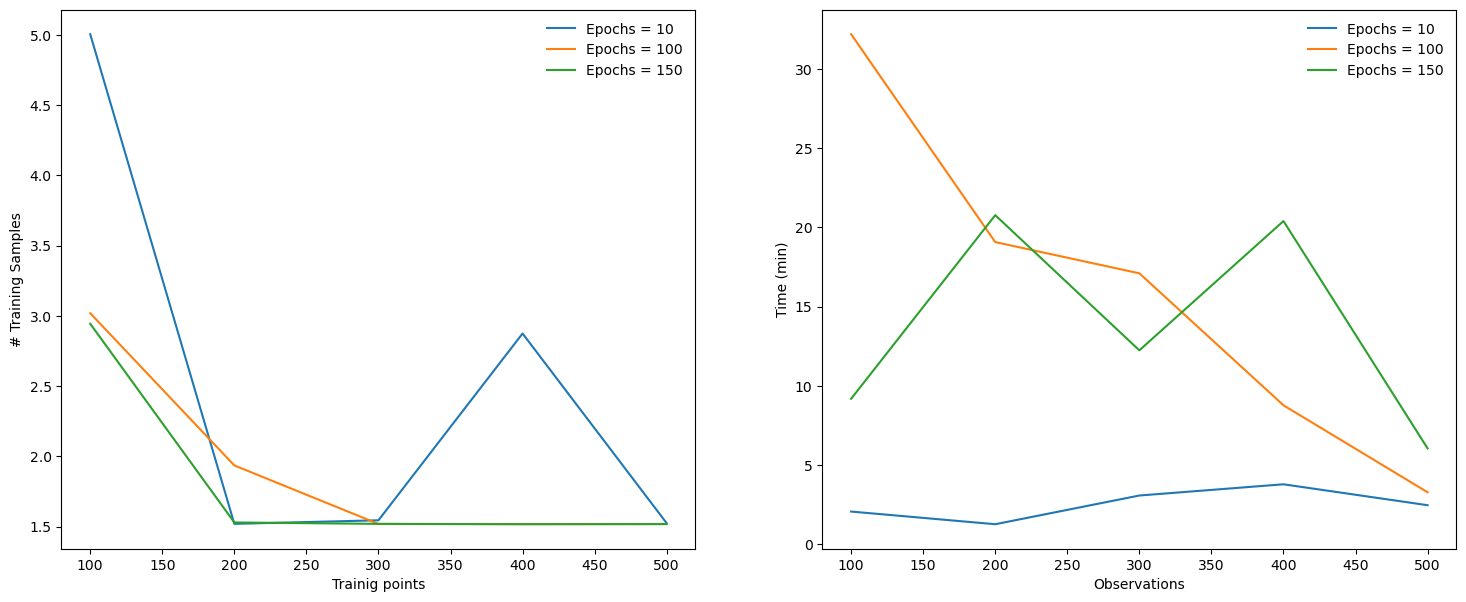

In [1106]:
fig = plt.figure(figsize=(18,7))
plt.subplots_adjust(hspace=0.25)

plt.subplot(1, 2, 1) 
for key in error.keys():
    plt.plot(nobs ,np.log(error[key]),label = "Epochs = " + key)

plt.xlabel("Trainig points")
plt.ylabel("# Training Samples")
plt.legend(frameon = False)

plt.subplot(1, 2, 2) 
for key in times.keys():
    plt.plot(nobs,np.array(times[key])/60,label = "Epochs = " + key)

plt.xlabel("Observations")
plt.ylabel("Time (min)")
plt.legend(frameon = False)

/tmp/ipykernel_4194/2069679779.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sqrt(np.prod(A)/(2*np.pi)) * np.exp(-0.5 * np.sum((A*((alpha_.reshape(-1,1)- mu_p)**2)),axis = 1)))
/tmp/ipykernel_4194/647453479.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(alpha_,200*np.exp(np.array(alpha_models[key_epoch][mdl],dtype=np.longdouble))/np.sum(np.exp(np.array(alpha_models[key_epoch][mdl],dtype=np.longdouble))),


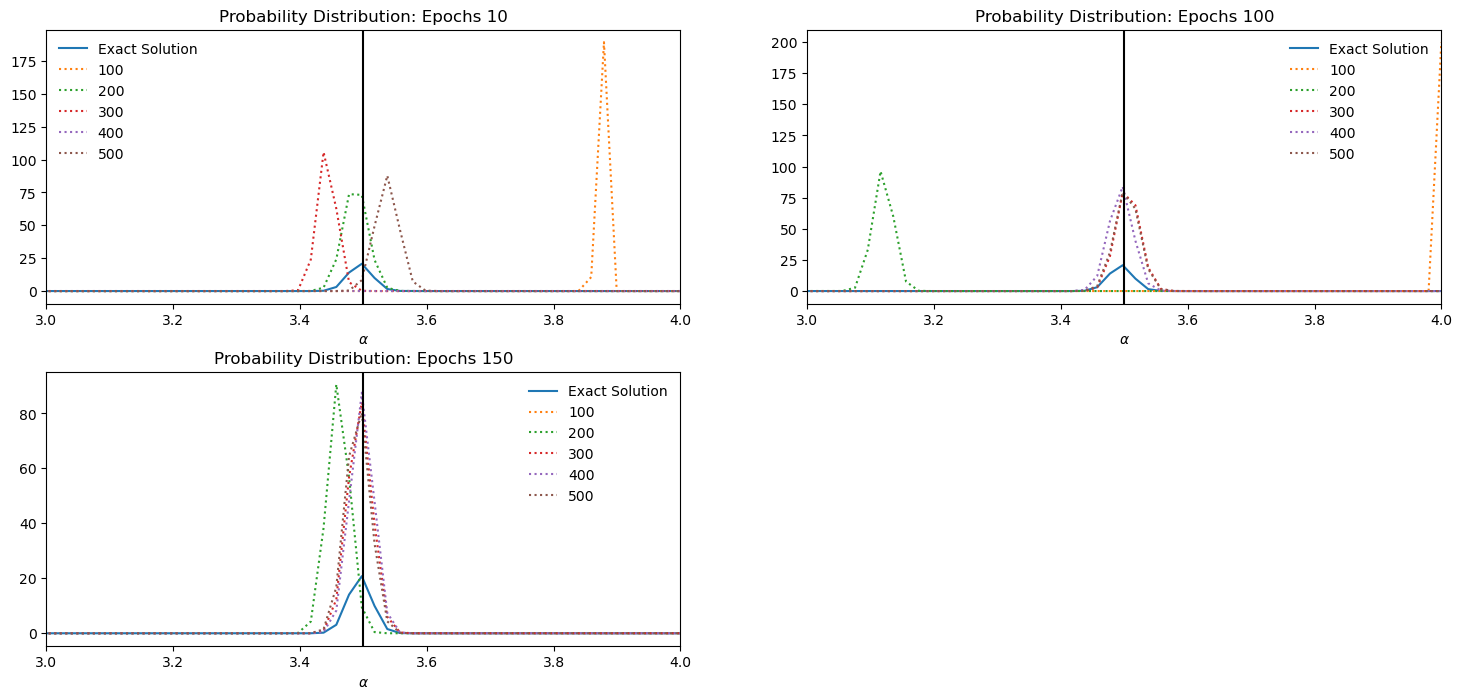

In [1107]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

for n, key_epoch in enumerate(alpha_models.keys()):

    plt.subplot(2, 2, n + 1)

    plt.plot(alpha_,np.exp(log_posterior_ex(alpha_,t,noise_sol_test,std,sig_0)) ,linestyle = '-', label = "Exact Solution")

    for mdl in alpha_models[key_epoch].keys():
        plt.plot(alpha_,200*np.exp(np.array(alpha_models[key_epoch][mdl],dtype=np.longdouble))/np.sum(np.exp(np.array(alpha_models[key_epoch][mdl],dtype=np.longdouble))),
                                                    linestyle = ':', label = mdl)

    plt.axvline(x = true_theta, color = 'black')

    plt.title(f"Probability Distribution: Epochs {key_epoch}")
    plt.xlabel(r"$\alpha$")
    plt.legend(frameon =False)
    plt.xlim(3,4)

## Prior Research

In [1120]:
mean, std = 0,0.1  #Gaussian Noise

min_param , max_param = 0, 10 #Range of Parameters for the parametric ODE

true_theta = 3.5

sig_0 = [0.01,1,100]

alpha_ = np.linspace( - 0.5,true_theta + 0.5,200)

/tmp/ipykernel_4194/2069679779.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sqrt(np.prod(A)/(2*np.pi)) * np.exp(-0.5 * np.sum((A*((alpha_.reshape(-1,1)- mu_p)**2)),axis = 1)))


(1.0, 4.0)

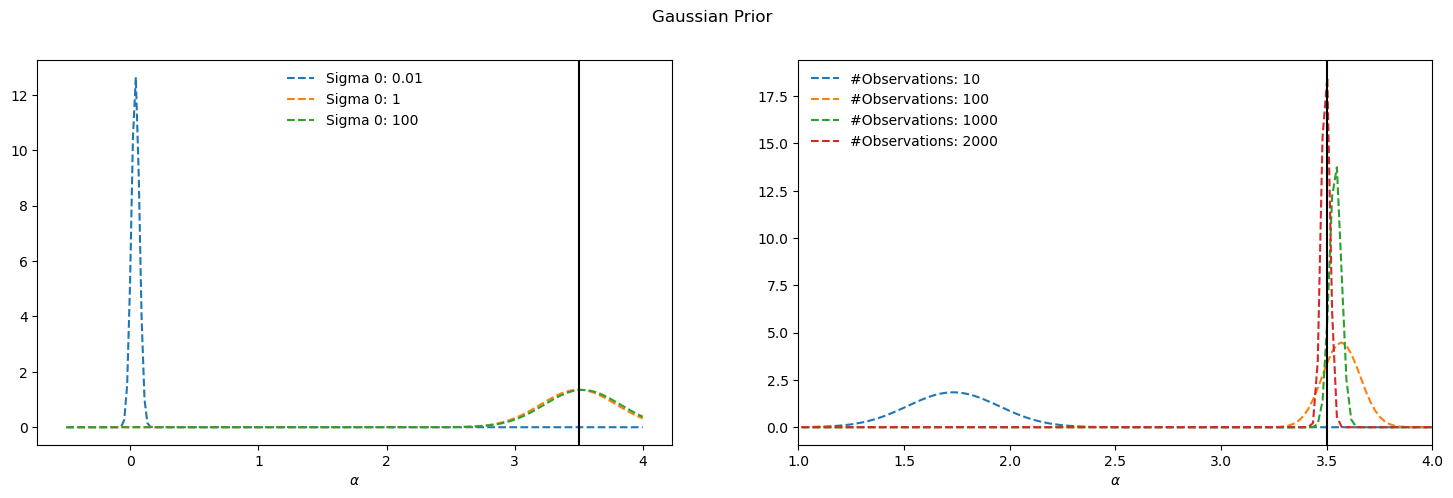

In [1140]:

fig = plt.figure(figsize=(18,5))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Gaussian Prior")

plt.subplot(1, 2,  1)
#seed  = 42
#np.random.seed(seed)

t, noise_sol_test = test_set(ns,10,true_theta,mean,std) #Test data for the MCMC

for s0 in sig_0:
    plt.plot(alpha_,np.exp(log_posterior_ex(alpha_,t,noise_sol_test,std,s0)) ,linestyle = '--', label = "Sigma 0: "+ str(s0))

plt.axvline(x = true_theta, color = 'black')
plt.legend(frameon = False)
plt.xlabel(r"$\alpha$")

plt.subplot(1, 2,  2)


for obs in [10,100,1000,2000]:

    t, noise_sol_test = test_set(ns,obs,true_theta,mean,std) #Test data for the MCMC

    plt.plot(alpha_,np.exp(log_posterior_ex(alpha_,t,noise_sol_test,std,.1)) ,linestyle = '--', label = "#Observations: "+ str(obs))

plt.axvline(x = true_theta, color = 'black')
plt.legend(frameon = False)
plt.xlabel(r"$\alpha$")
plt.xlim(1,4)

In [1131]:
def uni_log_posterior(alpha,t,y,sig):
    N = len(y)

    A = np.sum((np.sin(2*np.pi*t)/(2*np.pi*sig))**2)

    mu_p = np.sum((np.sin(2*np.pi*t)/(2*np.pi*sig**2)) * ((y -1)/A))

    return np.log(np.sqrt(np.prod(A)/(2*np.pi)) * np.exp(-0.5 * np.sum((A*((alpha.reshape(-1,1)- mu_p)**2)),axis = 1)))


/tmp/ipykernel_4194/2434397389.py:8: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sqrt(np.prod(A)/(2*np.pi)) * np.exp(-0.5 * np.sum((A*((alpha.reshape(-1,1)- mu_p)**2)),axis = 1)))


(3.0, 4.0)

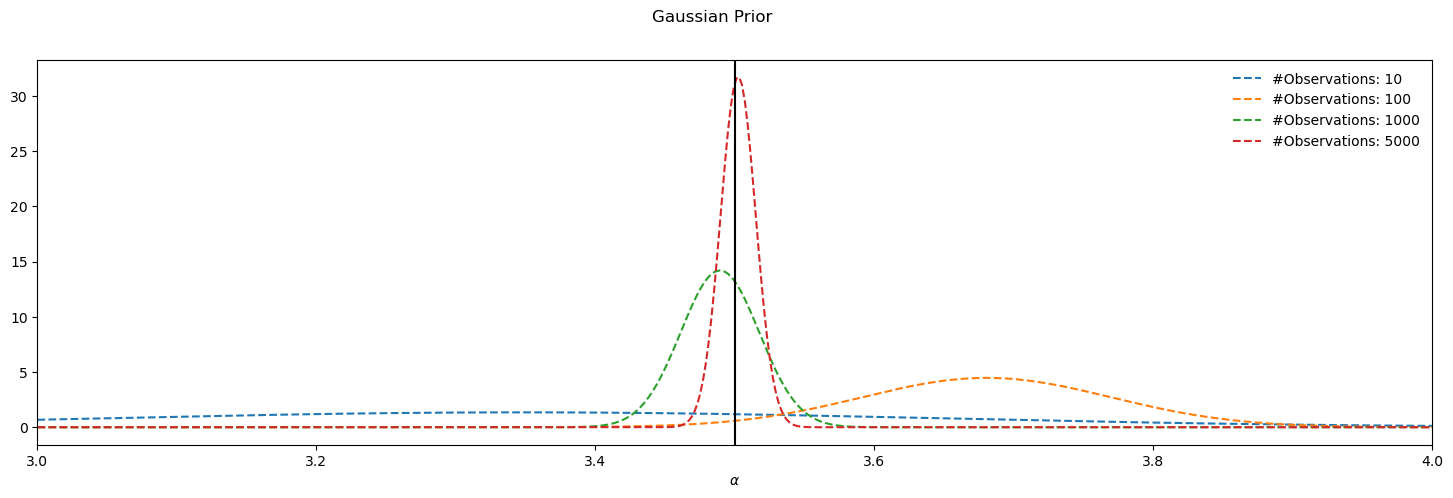

In [1295]:

fig = plt.figure(figsize=(18,5))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Gaussian Prior")

plt.subplot(1, 1,  1)
#seed  = 42
#np.random.seed(seed)

for obs in [10,100,1000,5000]:

    t, noise_sol_test = test_set(ns,obs,true_theta,mean,0.1) #Test data for the MCMC

    plt.plot(np.linspace( true_theta-0.5,true_theta + 0.5,500),np.exp(uni_log_posterior(np.linspace( true_theta-0.5,true_theta + 0.5,500),t,noise_sol_test,std)) ,linestyle = '--', label = "#Observations: "+ str(obs))

plt.axvline(x = true_theta, color = 'black')
plt.legend(frameon = False)
plt.xlabel(r"$\alpha$")
plt.xlim(3,4)